In [ ]:
!pip install pytorch_lightning datasets

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
import numpy as np
from datasets import load_dataset
import re
from collections import Counter
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
pl.seed_everything(42)

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

INFO:lightning_fabric.utilities.seed:Seed set to 42


PyTorch version: 2.9.0+cu126
PyTorch Lightning version: 2.6.0
CUDA available: True


In [ ]:
print("Loading AG News dataset...")
dataset = load_dataset("ag_news")

print(f"\nDataset structure:")
print(dataset)
print(f"\nTrain set size: {len(dataset['train'])}")
print(f"Test set size: {len(dataset['test'])}")

train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

train_texts = list(train_texts)
train_labels = list(train_labels)
test_texts = list(test_texts)
test_labels = list(test_labels)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels,
    test_size=0.1,
    random_state=42,
    stratify=train_labels
)

print(f"\nAfter split:")
print(f"Train: {len(train_texts)}")
print(f"Val: {len(val_texts)}")
print(f"Test: {len(test_texts)}")

class_names = ['World', 'Sports', 'Business', 'Sci/Tech']
print(f"\nClasses: {class_names}")

print("\nSample examples:")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"  Label: {train_labels[i]} ({class_names[train_labels[i]]})")
    print(f"  Text: {train_texts[i][:150]}...")

Loading AG News dataset...

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

Train set size: 120000
Test set size: 7600

After split:
Train: 108000
Val: 12000
Test: 7600

Classes: ['World', 'Sports', 'Business', 'Sci/Tech']

Sample examples:

Example 1:
  Label: 1 (Sports)
  Text: 10 seconds that change everything ATHENS - Ten seconds. Barely time enough to tie a shoe, wash a glass, get the paper off the porch. But when the mome...

Example 2:
  Label: 1 (Sports)
  Text: Charline Labonte rises to challenge Charline Labonte has served notice she wants to become the next starting goaltender of the Canadian women #39;s ho...

Example 3:
  Label: 2 (Business)
  Text: Ex-El Paso Traders Plead Guilty to False Reports Two more former natural gas traders for El Paso Corp. have pleaded guilty to reporting bogus deals in...


In [ ]:
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'
PAD_IDX = 0
UNK_IDX = 1

def simple_tokenize(text):
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

print("Building vocabulary...")
word_counter = Counter()
for text in train_texts:
    tokens = simple_tokenize(text)
    word_counter.update(tokens)

print(f"Total unique words: {len(word_counter)}")
print(f"Words with freq >= 2: {sum(1 for count in word_counter.values() if count >= 2)}")

vocab = {PAD_TOKEN: PAD_IDX, UNK_TOKEN: UNK_IDX}
vocab_size = 2

max_vocab_size = 30000
for word, count in word_counter.most_common():
    if count >= 2 and vocab_size < max_vocab_size:
        vocab[word] = vocab_size
        vocab_size += 1

print(f"\nVocabulary size: {len(vocab)}")
print(f"Top 10 words: {list(vocab.keys())[:10]}")

idx_to_word = {idx: word for word, idx in vocab.items()}

Building vocabulary...
Total unique words: 62617
Words with freq >= 2: 42450

Vocabulary size: 30000
Top 10 words: ['<pad>', '<unk>', 'the', 'to', 'a', 'of', 'in', 'and', 's', 'on']


In [ ]:
class AGNewsDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=128):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        tokens = simple_tokenize(text)
        indices = [self.vocab.get(token, UNK_IDX) for token in tokens]

        if len(indices) > self.max_len:
            indices = indices[:self.max_len]
        else:
            indices = indices + [PAD_IDX] * (self.max_len - len(indices))

        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

max_len = 128
train_dataset = AGNewsDataset(train_texts, train_labels, vocab, max_len=max_len)
val_dataset = AGNewsDataset(val_texts, val_labels, vocab, max_len=max_len)
test_dataset = AGNewsDataset(test_texts, test_labels, vocab, max_len=max_len)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

sample_text, sample_label = train_dataset[0]
print(f"\nSample:")
print(f"  Text shape: {sample_text.shape}")
print(f"  Label: {sample_label.item()} ({class_names[sample_label.item()]})")
print(f"  First 20 tokens: {sample_text[:20].tolist()}")

Train dataset size: 108000
Val dataset size: 12000
Test dataset size: 7600

Sample:
  Text shape: torch.Size([128])
  Label: 1 (Sports)
  First 20 tokens: [136, 1788, 12, 674, 2622, 377, 1835, 1788, 3693, 84, 861, 3, 1686, 4, 7541, 5329, 4, 5770, 229, 2]


In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=200, num_filters=100,
                 filter_sizes=[3, 4, 5], num_classes=4, dropout=0.5, use_batchnorm=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.use_batchnorm = use_batchnorm

        self.convs = nn.ModuleList()
        self.batchnorms = nn.ModuleList() if use_batchnorm else None

        for fs in filter_sizes:
            conv = nn.Conv1d(embed_dim, num_filters, kernel_size=fs)
            self.convs.append(conv)
            if use_batchnorm:
                self.batchnorms.append(nn.BatchNorm1d(num_filters))

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # B x T x d
        x = x.transpose(1, 2)  # B x d x T

        conv_outputs = []
        for i, conv in enumerate(self.convs):
            conv_out = conv(x)

            if self.use_batchnorm:
                conv_out = self.batchnorms[i](conv_out)

            conv_out = F.relu(conv_out)

            pooled = F.max_pool1d(conv_out, kernel_size=conv_out.size(2)).squeeze(2)
            conv_outputs.append(pooled)

        x = torch.cat(conv_outputs, dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
class TextCNNModule(pl.LightningModule):
    def __init__(self, vocab_size, embed_dim=200, num_filters=100,
             filter_sizes=[3, 4, 5], num_classes=4, dropout=0.5,
             lr=1e-3, use_batchnorm=True, scheduler_step_size=1,
             scheduler_gamma=0.5, weight_decay=1e-4):
        super().__init__()
        self.save_hyperparameters()

        self.model = TextCNN(vocab_size, embed_dim, num_filters, filter_sizes,
                        num_classes, dropout, use_batchnorm)

        self.lr = lr
        self.weight_decay = weight_decay
        self.scheduler_step_size = scheduler_step_size
        self.scheduler_gamma = scheduler_gamma

        self.train_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_acc = MulticlassAccuracy(num_classes=num_classes)
        self.test_acc = MulticlassAccuracy(num_classes=num_classes)

        self.val_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')
        self.test_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')

        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []
        self.val_f1s = []
        self.learning_rates = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        self.train_acc(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=True)

        if self.current_epoch == 0 or batch_idx == 0:
            self.train_losses.append(loss.item())

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        self.val_acc(logits, y)
        self.val_f1(logits, y)

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def on_validation_epoch_end(self):
        self.val_losses.append(self.trainer.callback_metrics['val_loss'].item())
        self.val_accs.append(self.trainer.callback_metrics['val_acc'].item())
        self.val_f1s.append(self.trainer.callback_metrics['val_f1'].item())

        current_lr = self.optimizers().param_groups[0]['lr']
        self.learning_rates.append(current_lr)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)

        scheduler = {
            'scheduler': torch.optim.lr_scheduler.StepLR(
                optimizer,
                step_size=self.scheduler_step_size,
                gamma=self.scheduler_gamma
            ),
            'interval': 'epoch',
            'frequency': 1
        }

        return [optimizer], [scheduler]

In [ ]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 844
Val batches: 94
Test batches: 60


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
vocab_size = len(vocab)

model = TextCNNModule(
    vocab_size=vocab_size,
    embed_dim=300,
    num_filters=256,
    filter_sizes=[2, 3, 4, 5, 6],
    num_classes=4,
    dropout=0.4,
    lr=2e-3,
    use_batchnorm=True,
    scheduler_step_size=2,
    scheduler_gamma=0.85
)

def configure_optimizers_without_recursion(self):
    optimizer = torch.optim.AdamW(
        self.parameters(),
        lr=self.lr,
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',  # Мониторим максимизацию метрики
        factor=0.5,  # Уменьшаем LR в 2 раза
        patience=2,  # Ждем 2 эпохи без улучшения
        min_lr=1e-6,
    )

    return {
        'optimizer': optimizer,
        'lr_scheduler': {
            'scheduler': scheduler,
            'monitor': 'val_f1',  # Мониторим F1
            'interval': 'epoch',
            'frequency': 1
        }
    }

TextCNNModule.configure_optimizers = configure_optimizers_without_recursion

checkpoint_callback = ModelCheckpoint(
    monitor='val_f1',
    dirpath='./checkpoints',
    filename='textcnn-agnews-best-f1-{epoch:02d}-{val_f1:.3f}',
    save_top_k=3,
    mode='max',
    save_last=True,
    save_weights_only=True
)

early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_f1',
    patience=5,
    mode='max',
    min_delta=0.001,
    verbose=True
)

lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval='epoch')

swa_callback = pl.callbacks.StochasticWeightAveraging(
    swa_lrs=1e-2,
    swa_epoch_start=8,
    annealing_epochs=3,
    annealing_strategy='linear'
)

class SimpleMetricsCallback(pl.Callback):
    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        if 'val_f1' in metrics:
            print(f"Epoch {trainer.current_epoch}: Val F1: {metrics['val_f1']:.4f}")

simple_metrics_callback = SimpleMetricsCallback()

trainer = pl.Trainer(
    max_epochs=15,
    accelerator='auto',
    devices=1,
    callbacks=[checkpoint_callback, early_stopping, lr_monitor, simple_metrics_callback],
    enable_progress_bar=True,
    log_every_n_steps=25,
    gradient_clip_val=0.5,
    accumulate_grad_batches=1,
    precision=16,
    deterministic=False,
    enable_model_summary=False,
    check_val_every_n_epoch=1
)

print("Starting training...")
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

try:
    start_time = time.time()
    trainer.fit(model, train_loader, val_loader)
    total_time = time.time() - start_time

    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Average time per epoch: {total_time / max(1, trainer.current_epoch):.2f} seconds")

    if checkpoint_callback.best_model_path:
        print(f"\nBest model saved at: {checkpoint_callback.best_model_path}")
        print(f"Best validation F1: {checkpoint_callback.best_model_score:.4f}")

except RecursionError as e:
    print(f"RecursionError: {e}")
    print("\nTrying simplified configuration...")

    trainer = pl.Trainer(
        max_epochs=10,
        accelerator='auto',
        devices=1,
        callbacks=[checkpoint_callback, early_stopping],
        enable_progress_bar=True,
        log_every_n_steps=50
    )

    start_time = time.time()
    trainer.fit(model, train_loader, val_loader)
    total_time = time.time() - start_time

    print(f"\nTraining completed in {total_time:.2f} seconds")

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

Starting training...
Model parameters: 10,544,964


Epoch 0: Val F1: 0.1530

Epoch 0: Val F1: 0.9077

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1 improved. New best score: 0.908


Epoch 1: Val F1: 0.9181

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1 improved by 0.010 >= min_delta = 0.001. New best score: 0.918


Epoch 2: Val F1: 0.9212

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1 improved by 0.003 >= min_delta = 0.001. New best score: 0.921


Epoch 3: Val F1: 0.9246

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_f1 improved by 0.003 >= min_delta = 0.001. New best score: 0.925


Epoch 4: Val F1: 0.9230

Epoch 5: Val F1: 0.9210

Epoch 6: Val F1: 0.9198

Epoch 7: Val F1: 0.9230

Epoch 8: Val F1: 0.9228

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_f1 did not improve in the last 5 records. Best score: 0.925. Signaling Trainer to stop.



Training completed in 322.63 seconds
Average time per epoch: 35.85 seconds

Best model saved at: /content/checkpoints/textcnn-agnews-best-f1-epoch=03-val_f1=0.925.ckpt
Best validation F1: 0.9246



ВИЗУАЛИЗАЦИЯ МЕТРИК ОБУЧЕНИЯ


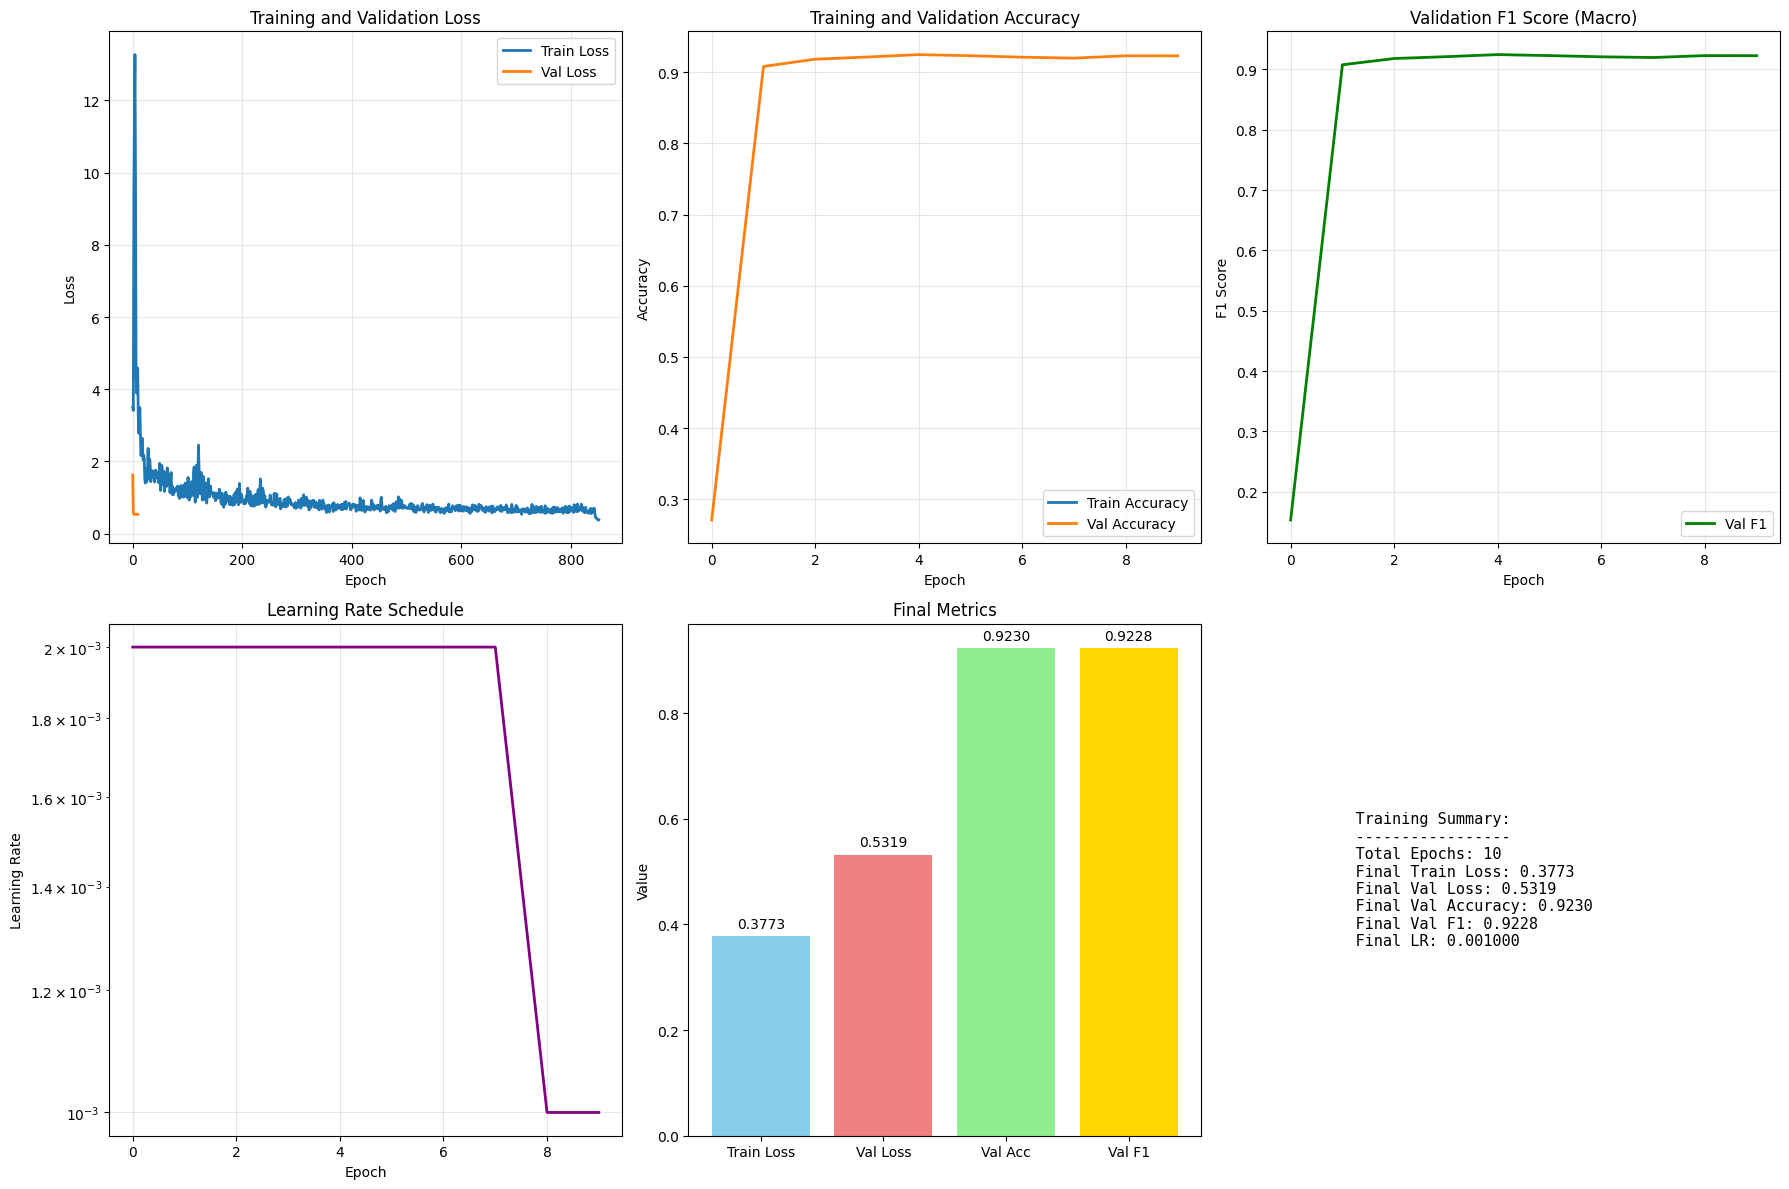

In [ ]:
def plot_training_metrics(model_module):
    """Визуализация метрик обучения"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Loss curves
    axes[0, 0].plot(model_module.train_losses, label='Train Loss', linewidth=2)
    axes[0, 0].plot(model_module.val_losses, label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Accuracy curves
    axes[0, 1].plot(model_module.train_accs, label='Train Accuracy', linewidth=2)
    axes[0, 1].plot(model_module.val_accs, label='Val Accuracy', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. F1 Score
    axes[0, 2].plot(model_module.val_f1s, label='Val F1', linewidth=2, color='green')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('F1 Score')
    axes[0, 2].set_title('Validation F1 Score (Macro)')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Learning rate schedule
    axes[1, 0].plot(model_module.learning_rates, linewidth=2, color='purple')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_yscale('log')

    # 5. Bar plot: Final metrics
    metrics = ['Train Loss', 'Val Loss', 'Val Acc', 'Val F1']
    values = [
        model_module.train_losses[-1] if model_module.train_losses else 0,
        model_module.val_losses[-1] if model_module.val_losses else 0,
        model_module.val_accs[-1] if model_module.val_accs else 0,
        model_module.val_f1s[-1] if model_module.val_f1s else 0
    ]

    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']
    bars = axes[1, 1].bar(metrics, values, color=colors)
    axes[1, 1].set_title('Final Metrics')
    axes[1, 1].set_ylabel('Value')

    # Добавляем значения на столбцы
    for bar, val in zip(bars, values):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{val:.4f}', ha='center', va='bottom')

    axes[1, 2].axis('off')

    final_train_loss = f"{model_module.train_losses[-1]:.4f}" if model_module.train_losses else "N/A"
    final_val_loss   = f"{model_module.val_losses[-1]:.4f}"   if model_module.val_losses   else "N/A"
    final_val_acc    = f"{model_module.val_accs[-1]:.4f}"     if model_module.val_accs     else "N/A"
    final_val_f1     = f"{model_module.val_f1s[-1]:.4f}"      if model_module.val_f1s      else "N/A"
    final_lr         = f"{model_module.learning_rates[-1]:.6f}" if model_module.learning_rates else "N/A"

    summary_text = f"""
    Training Summary:
    -----------------
    Total Epochs: {len(model_module.val_losses)}
    Final Train Loss: {final_train_loss}
    Final Val Loss: {final_val_loss}
    Final Val Accuracy: {final_val_acc}
    Final Val F1: {final_val_f1}
    Final LR: {final_lr}
    """
    axes[1, 2].text(0.1, 0.5, summary_text, fontsize=11,
                verticalalignment='center', fontfamily='monospace')


    plt.tight_layout()
    plt.savefig('metrics_viz.png')
    plt.show()

print("\n" + "="*50)
print("ВИЗУАЛИЗАЦИЯ МЕТРИК ОБУЧЕНИЯ")
print("="*50)
plot_training_metrics(model)

In [ ]:
test_acc = MulticlassAccuracy(num_classes=4)
test_f1 = MulticlassF1Score(num_classes=4, average='macro')

model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)

        test_acc(logits, y)
        test_f1(logits, y)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

print("\n" + "="*50)
print("РЕЗУЛЬТАТЫ НА ТЕСТОВОМ НАБОРЕ")
print("="*50)
print(f"Test Accuracy: {test_acc.compute().item():.4f}")
print(f"Test Macro F1: {test_f1.compute().item():.4f}")

from sklearn.metrics import classification_report

print("\n" + "="*50)
print("ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ")
print("="*50)
print(classification_report(all_labels, all_preds,
                           target_names=class_names, digits=3))


РЕЗУЛЬТАТЫ НА ТЕСТОВОМ НАБОРЕ
Test Accuracy: 0.9214
Test Macro F1: 0.9212

ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ
              precision    recall  f1-score   support

       World      0.923     0.915     0.919      1900
      Sports      0.957     0.985     0.971      1900
    Business      0.901     0.884     0.892      1900
    Sci/Tech      0.903     0.902     0.902      1900

    accuracy                          0.921      7600
   macro avg      0.921     0.921     0.921      7600
weighted avg      0.921     0.921     0.921      7600



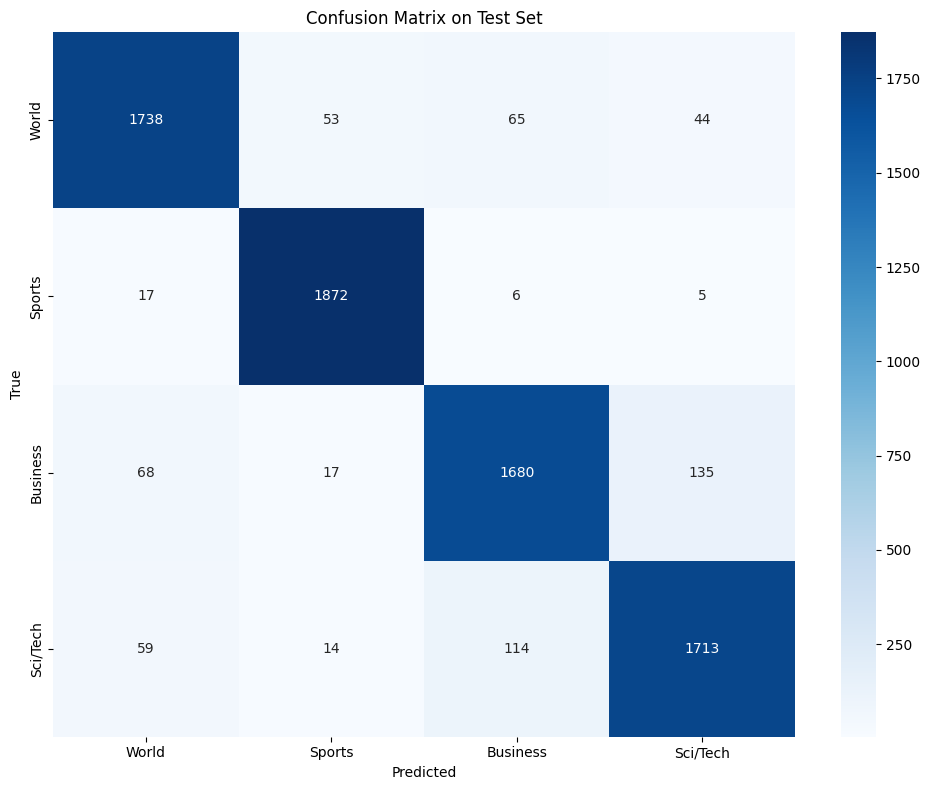

World: Precision=0.923, Recall=0.915, F1=0.919
Sports: Precision=0.957, Recall=0.985, F1=0.971
Business: Precision=0.901, Recall=0.884, F1=0.892
Sci/Tech: Precision=0.903, Recall=0.902, F1=0.902


In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

for i, class_name in enumerate(class_names):
    precision = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() > 0 else 0
    recall = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    print(f"{class_name}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")